# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
#from numba import cuda
from scipy import spatial, sparse

In [ ]:
dataLoc = '../data/'
adjLoc = '../adj/'

In [2]:
data = pd.read_csv(dataLoc+'fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

/home/mark/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mark/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


making doy relative to year, equal to days since 1/1/1992 now

In [3]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

In [4]:
data2015 = data[data.FIRE_YEAR == 2015]
data2015 = data2015.sort_values(by = "DISCOVERY_DOY", kind='mergesort')

distance matrix calculation using cuda from: https://stackoverflow.com/questions/46655878/how-to-calculate-pairwise-distance-matrix-on-the-gpu

not integrated into get_A yet

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)

    return out

In [5]:
def get_A(data, dist, blocksize=10000):
    
    print("Setting up...")
    values = np.array(data.values)
    
    # Dimensions should be be (N, K), even if K = 1 columns. Reshape if needed
    if len(values.shape) == 1:
        values = values.reshape((values.shape[0], 1))
    N = values.shape[0]
        
    print("Initializing sparse matrix...")
    # Initialize sparse matrix
    A = sparse.lil_matrix((N,N))
    
    # Divide-and-conquer: split the overall big adjacency matrix into
    # blocksize x blocksize chunks, then use scipy's super-fast C implementation for distance matrix
    for i in range(N // blocksize + 1):
        for j in range(i, N // blocksize + 1):
            
            print((i,j))
            
            # Make sure we don't go out of bounds if N isn't divisible by blocksize!
            row_start = i * blocksize
            row_end   = min((i+1) * blocksize, N-1)
            col_start = j * blocksize
            col_end   = min((j+1) * blocksize, N-1)
            
            # Get the relevant values for this block
            #print("Get row/col vals")
            row_values = values[row_start:row_end, :]
            col_values = values[col_start:col_end, :]
            
            # Get distance matrix for this block
            #print("Calculate distance")
            # use cuda implementation from stackoverflow
            D = spatial.distance.cdist(row_values, col_values)
            
            # Threshold it
            #print("Threshold it")
            subA = D <= dist
            
            # Insert into matrix
            #print("Insert into matrix")
            A[row_start:row_end, col_start:col_end] = subA
            
            # This graph is undirected--A will be symmetric! So set the other side now
            if i != j:
                #print("Insert into matrix, transposed")
                A[col_start:col_end, row_start:row_end] = subA.T
            
    # Convert to CSR format for fast arithmetic
    #print("Convert CSR")
    A = A.tocsr()
            
    return A

In [6]:
attr_time = data2015[["DAY"]]
attr_space = data2015[["LATITUDE", "LONGITUDE"]]

In [7]:
gc.collect()

0

# Using time
Threshold = 1 day

In [8]:
%%time
Atime = get_A(attr_time, 1.01, blocksize=20000)

Setting up...
Initializing sparse matrix...
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
CPU times: user 5min 10s, sys: 1min 36s, total: 6min 47s
Wall time: 6min 47s


### Degree distribution

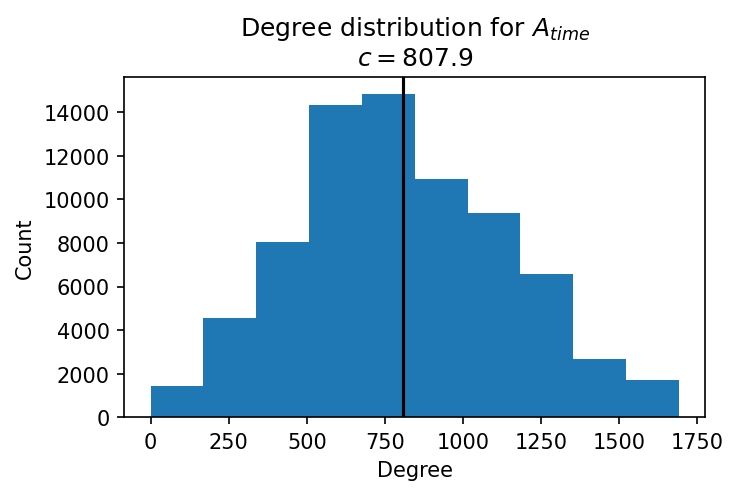

In [9]:
deg = Atime.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{time}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Using space
Threshold = 1$^\circ$ radius

In [10]:
%%time
Aspace = get_A(attr_space, 1.0, blocksize=20000)

Setting up...
Initializing sparse matrix...
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)
CPU times: user 5min 52s, sys: 1min 33s, total: 7min 25s
Wall time: 7min 25s


### Degree distribution

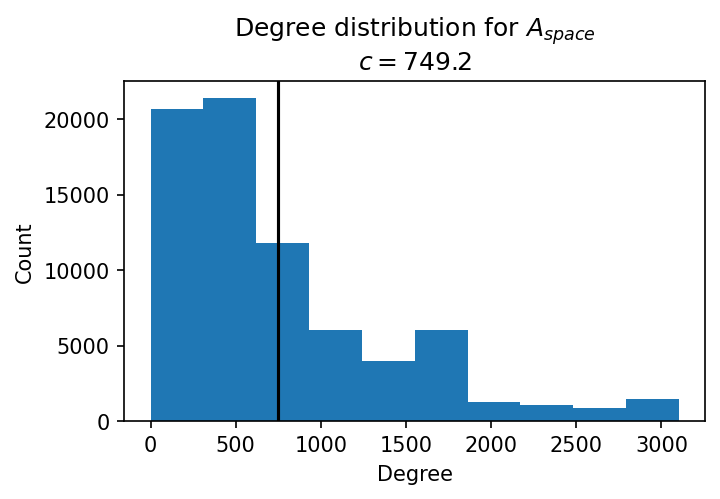

In [11]:
deg = Aspace.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{space}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Using both
Threshold: only if edge meets **both** criteria

In [12]:
%%time
Aboth = Aspace.multiply(Atime)

CPU times: user 312 ms, sys: 62.5 ms, total: 375 ms
Wall time: 360 ms


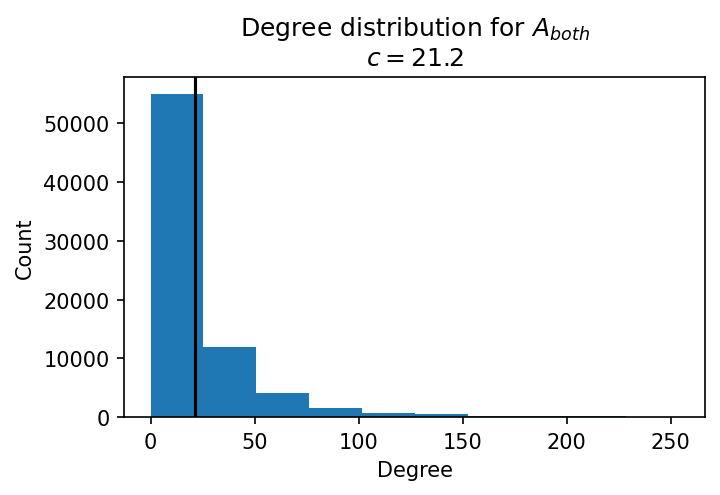

In [13]:
deg = Aboth.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Save sparse matrices to disk

In [14]:
with open(adjLoc+'A_time.pkl', 'wb') as f:
    pickle.dump(Atime, f)
    
with open(adjLoc+'A_space.pkl', 'wb') as f:
    pickle.dump(Aspace, f)

with open(adjLoc+'A_both.pkl', 'wb') as f:
    pickle.dump(Aboth, f)

In [15]:
data.DAY

0         140
1         218
2         279
3         298
4         159
         ... 
74486    8664
74487    8673
74488    8517
74489    8682
74490    8468
Name: DAY, Length: 1880465, dtype: int64